In [1]:
import os
import pandas as pd
hbn_path = "/home/ryan/Code/DMZ/hbn.csv"

### 1. The HBN column names are malformed, making csv parsing software fail or return nonsensical results

Whenever a malformed column name exists, e.g. "BIA,""Days_Baseline"", this column has all nan values and there exists another column which is correctly formed, e.g. "BIA,Days_Baseline" which has the true values.

In [2]:
with open(hbn_path, "r") as f:
    columns = f.readline()
    print('Correctly formed, "Instrument,Variable"')
    print(columns[:40], '\n')
    print('Incorrectly formed, "Instrument,""Variable""')
    print(columns[6871:8100])

Correctly formed, "Instrument,Variable"
"Identifiers","ACE,ACE_01","ACE,ACE_02", 

Incorrectly formed, "Instrument,""Variable""
"BIA,""Age"","BIA,""BMC"","BIA,""BMI"","BIA,""BMR"","BIA,""DEE"","BIA,""Days_Baseline"","BIA,""ECW"","BIA,""EID"","BIA,""FFM"","BIA,""FFMI"","BIA,""FMI"","BIA,""Fat"","BIA,""Frame"","BIA,""Height"","BIA,""ICW"","BIA,""LDM"","BIA,""LST"","BIA,""SMM"","BIA,""START_DATE"","BIA,""Season"","BIA,""Sex"","BIA,""Study"","BIA,""Study_Site"","BIA,""TBW"","BIA,""Weight"","BIA,""Year"","BIA,Administration","BIA,Comment_ID","BIA,Data_entry","BIA,Days_Baseline","BIA,EID","BIA,PSCID","BIA,START_DATE","BIA,Season","BIA,Site","BIA,Study","BIA,Visit_label","BIA,Year","Barratt,Administration","Barratt,Barratt_P1_Edu","Barratt,Barratt_P1_Occ","Barratt,Barratt_P2_Edu","Barratt,Barratt_P2_Occ","Barratt,Barratt_Total","Barratt,Barratt_Total_Edu","Barratt,Barratt_Total_Occ","Barratt,Comment_ID","Barratt,Data_entry","Barratt,Days_Baseline","Barratt,EID","Barratt,PSCID","Barratt,START_

To fix:
1. Parse .csv, but with "," used as a delimeter rather than just ,
2. Remove the first character from the first column name, and the last character from the last column name
2. Remove all columns which have a " character in the column name

In [3]:
hbn = pd.read_csv(hbn_path, engine='python',
                  dtype="unicode", sep = '","')
columns = list(hbn.columns)
columns[0] = columns[0][1:]
columns[-1] = columns[-1][:-1]
hbn.columns = columns
keep_columns = list(filter(lambda x: '"' not in x, hbn.columns))
hbn = hbn[keep_columns]

### 2. More than one unique delimter for a NA value. e.g. here, '.' and 'nan' are used. In other instances, 'n/a' is also used

In [4]:
import numpy as np
print(np.unique(hbn["NLES_SR,NLES_SR_Upset_Avg"].as_matrix()))

['.' '0' '0.67' '1' '1.2' '1.33' '1.4' '1.5' '1.6' '1.67' '1.71' '1.75' '2'
 '2.07' '2.11' '2.17' '2.2' '2.22' '2.25' '2.27' '2.29' '2.33' '2.37E+11'
 '2.4' '2.43' '2.5' '2.57' '2.6' '2.62' '2.64' '2.67' '2.7' '2.71' '2.75'
 '2.78' '2.8' '2.83' '2.87' '2.88' '2.89' '2.9' '3' '3.1' '3.13' '3.17'
 '3.2' '3.22' '3.25' '3.33' '3.38' '3.4' '3.45' '3.5' '3.55' '3.56' '3.57'
 '3.6' '3.63' '3.67' '3.7' '3.71' '3.75' '3.77' '3.8' '3.86' '4' '4.08'
 '4.11' '4.17' '4.18' '4.2' '4.25' '4.33' '4.38' '4.43' '4.45' '4.5' '4.6'
 '4.7' '5' '5.75' '6.14E+13' 'nan']


To fix:
1. Replace all instances of '.', 'nan', 'NaN', 'NA', 'n/a' in the data frame with one value (here, we use a special value in numpy called np.nan)

In [5]:
print("Before replacement number of nans:", hbn.isnull().sum().sum())

Before replacement number of nans: 0


In [6]:
hbn.replace(".", "nan", inplace=True)
hbn.replace("n/a", "nan", inplace=True)
hbn.replace("NaN", "nan", inplace=True)
hbn.replace("NA", "nan", inplace=True)

In [7]:
print("After replacement number of nans:", hbn.isnull().sum().sum())

After replacement number of nans: 0


### The NLES_SR,NLES_SR_Upset_Avg column has a few extreme outliers which may just be bad entries

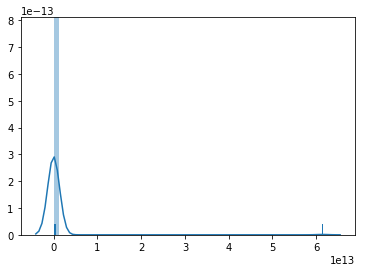

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
array1 = hbn["NLES_SR,NLES_SR_Upset_Avg"].as_matrix().astype(float)
array1 = array1[~np.isnan(array1)]
sns.distplot(array1, rug=True)
plt.show()

To fix: We just remove the column entirely

In [9]:
del hbn["NLES_SR,NLES_SR_Upset_Avg"]

### The DailyMeds,hours_sleep column has a few extreme outliers which may just be bad entries

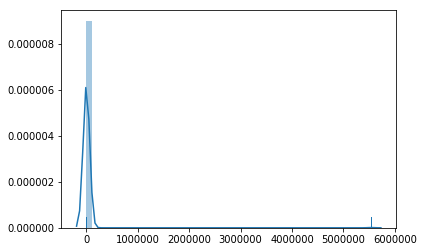

In [10]:
array1 = hbn["DailyMeds,hours_sleep"].as_matrix().astype(float)
array1 = array1[~np.isnan(array1)]
sns.distplot(array1, rug=True)
plt.show()

To fix: We just remove the column entirely

In [11]:
del hbn["DailyMeds,hours_sleep"]

### Many categorical variables are redundant with minor changes, e.g. 
* upper case vs. lower case
  * ADHD Inattentive Type vs. ADHD Inattentive type
* presence of hyphens
  * Attention Deficit Hyperactivity Disorder vs. Attention-Deficit Hyperactivity Disorder vs. Attention-Deficit/Hyperactivity Disorder vs. Attention-Deficit/Hyperactivity Disorder *with a space at the end*
* Including other special characters
  * Tourette's Disorder vs. Tourettes Disorder

In [12]:
array1 = hbn["ConsensusDx,DX_01"]
array1 = array1[[False if x is np.nan else True for x in array1]]
np.unique(array1)

array(['ADHD Inattentive Type', 'ADHD Inattentive type',
       'ADHD-Combined Type', 'ADHD-Hyperactive/Impulsive Type',
       'ADHD-Inattentive Type', 'Acute Stress Disorder',
       'Adjustment Disorder, with Mixed Emotions and Conduct',
       'Adjustment Disorders', 'Agoraphobia',
       'Attention Deficit Hyperactivity Disorder',
       'Attention Deficit Hyperactivity Disorder Combined Presentation',
       'Attention-Deficit Hyperactivity Disorder',
       'Attention-Deficit/Hyperactivity Disorder',
       'Attention-Deficit/Hyperactivity Disorder ',
       'Autism Spectrum Disorder', 'Bipolar I Disorder',
       'Bipolar II Disorder', 'Borderline Intellectual Functioning',
       'Cannabis Use Disorder', 'Conduct Disorder-Childhood-onset type',
       'Disruptive Mood Dysregulation Disorder', 'Enuresis',
       'Gender Dysphoria in Children', 'Generalized Anxiety Disorder',
       'Intellectual DIsability (moderate)',
       'Intellectual Disability-Mild', 'Intellectual Disabi

To fix:
1. If the categorical array is x = [s1, s2, ..., sn], Hash each string si to si', with the hash function removing all non alpha-numeric characters and making the entire string lower case
2. For each string si', replace all sj where sj' = si' with si 

In [13]:
import re
def stringhash(string):
    return re.sub(r'\W+', '', string).lower()
columns = np.array(list(map(stringhash, array1)))
for a, c in zip(array1, columns):
    array1[columns == c] = a
np.unique(array1)

array(['ADHD-Combined Type', 'ADHD-Hyperactive/Impulsive Type',
       'ADHD-Inattentive Type', 'Acute Stress Disorder',
       'Adjustment Disorder, with Mixed Emotions and Conduct',
       'Adjustment Disorders', 'Agoraphobia',
       'Attention Deficit Hyperactivity Disorder Combined Presentation',
       'Attention-Deficit/Hyperactivity Disorder ',
       'Autism Spectrum Disorder', 'Bipolar I Disorder',
       'Bipolar II Disorder', 'Borderline Intellectual Functioning',
       'Cannabis Use Disorder', 'Conduct Disorder-Childhood-onset type',
       'Disruptive Mood Dysregulation Disorder', 'Enuresis',
       'Gender Dysphoria in Children', 'Generalized Anxiety Disorder',
       'Intellectual Disability-Mild', 'Intellectual Disability-Moderate',
       'Intellectual Disability-Severe', 'Intermittent Explosive Disorder',
       'Language Disorder',
       'Learning Disorder with Impairment in Reading ',
       'Major Depressive Disorder', 'No Diagnosis Given',
       'Obsessive-Com

In [14]:
def convertDtype(l):
    try:
        return np.array(l, dtype="float")
    except:
        pass
    l = np.array(l, dtype=str)
    l[l == 'nan'] = 'NA'
    return l

# Find out the data type of each column
d = []
for c in hbn.columns:
    d.append(convertDtype(list(hbn[c])))
    #print("Converting", c, end="\r") 

# Make a new dataframe with the converted types
newcolumns = hbn.columns
newindex = hbn.index
D = list(d)
D = pd.DataFrame(dict(zip(newcolumns, D)))

# Determine which columns are categorical
keep = (D.dtypes == "float64").as_matrix()
cat = D.columns[~keep]

# Apply the string hash transform to each categorical column
for c in cat:
    array1 = D[c].as_matrix()
    columns = np.array(list(map(stringhash, array1)))
    for a, c in zip(array1, columns):
        array1[columns == c] = a
    D[c] = array1

In [15]:
np.unique(D["ConsensusDx,DX_01"])

array(['ADHD-Combined Type', 'ADHD-Hyperactive/Impulsive Type',
       'ADHD-Inattentive Type', 'Acute Stress Disorder',
       'Adjustment Disorder, with Mixed Emotions and Conduct',
       'Adjustment Disorders', 'Agoraphobia',
       'Attention Deficit Hyperactivity Disorder Combined Presentation',
       'Attention-Deficit/Hyperactivity Disorder ',
       'Autism Spectrum Disorder', 'Bipolar I Disorder',
       'Bipolar II Disorder', 'Borderline Intellectual Functioning',
       'Cannabis Use Disorder', 'Conduct Disorder-Childhood-onset type',
       'Disruptive Mood Dysregulation Disorder', 'Enuresis',
       'Gender Dysphoria in Children', 'Generalized Anxiety Disorder',
       'Intellectual Disability-Mild', 'Intellectual Disability-Moderate',
       'Intellectual Disability-Severe', 'Intermittent Explosive Disorder',
       'Language Disorder',
       'Learning Disorder with Impairment in Reading ',
       'Major Depressive Disorder', 'NA', 'No Diagnosis Given',
       'Obsessi

Now D contains the tidy dataset